In [47]:
print("Hello, World!")

Hello, World!


In [48]:

import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: d:\LLMOps_course\automated-research-report-generation


In [49]:
from research_and_analyst.utils.model_loader import ModelLoader


In [50]:
model_loader = ModelLoader()

{"timestamp": "2025-10-11T09:39:31.202815Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2025-10-11T09:39:31.204811Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-11T09:39:31.205881Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-10-11T09:39:31.208383Z", "level": "warning", "event": "ASTRA_DB_API_ENDPOINT is missing from environment"}
{"timestamp": "2025-10-11T09:39:31.210910Z", "level": "warning", "event": "ASTRA_DB_APPLICATION_TOKEN is missing from environment"}
{"timestamp": "2025-10-11T09:39:31.212907Z", "level": "warning", "event": "ASTRA_DB_KEYSPACE is missing from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-10-11T09:39:31.216907Z", "level": "info", "event": "YAML config loaded"}


In [51]:
llm=model_loader.load_llm()

{"provider": "openai", "model": "gpt-4o-mini", "timestamp": "2025-10-11T09:39:31.228872Z", "level": "info", "event": "Loading LLM"}


In [52]:
llm.invoke("hi").content

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Hello! How can I assist you today?'

In [53]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [54]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

health
Analyst( name="Dr. Neha Patel", role="Medical Data Scientist", affiliation="Stanford Medicine", description="Focuses on predictive models for patient outcomes." ),

Analyst( name="Dr. Arun Verma", role="Ethics Researcher", affiliation="WHO", description="Explores ethical implications of AI in diagnostics." ), Analyst( name="Ms. Priya Sharma", role="Policy Analyst", affiliation="Ministry of Health", description="Investigates AI policy and compliance frameworks." )

In [55]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [56]:
Analyst(
    name="sunny savita",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

Analyst(name='sunny savita', role='genai eng', affiliation='AI Research LAB', description='I am genai developer as well as mentor')

In [57]:
analyst = Analyst(
    name="sunny savita",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

In [58]:

analyst.name

'sunny savita'

In [59]:
analyst.role

'genai eng'

In [60]:
analyst.affiliation

'AI Research LAB'

In [61]:
print(analyst.persona)

Name: sunny savita
Role: genai eng
Affiliation: AI Research LAB
Description: I am genai developer as well as mentor



In [62]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [63]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

In [64]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [65]:
Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
    ),

(Analyst(name='Dr. Neha Patel', role='Medical Data Scientist', affiliation='Stanford Medicine', description='Focuses on predictive models for patient outcomes.'),)

In [66]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [67]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


In [68]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

In [69]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Emily Carter', role='Public Health Researcher', affiliation='Global Health Institute', description='Dr. Carter focuses on the impact of social determinants on health outcomes, particularly in underserved communities. Her work aims to provide actionable insights for policymakers to improve health equity.'),
  Analyst(name='Dr. Raj Patel', role='Health Data Analyst', affiliation='National Institute of Health Analytics', description='Dr. Patel specializes in the analysis of large health datasets to identify trends in disease prevalence and treatment efficacy. His goal is to leverage data to inform clinical practices and enhance patient care.')]}

In [70]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [71]:
def should_continue(state):
    """ Return the next node to execute """
    human_analyst_feedback = state.get("human_analyst_feedback",None)
    if human_analyst_feedback:
        return "create_analyst"

In [72]:
from IPython.display import Image, display

First Workflow

In [73]:
builder = StateGraph(GenerateAnalystsState)


In [74]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [75]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [76]:

memory = MemorySaver()

In [77]:
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

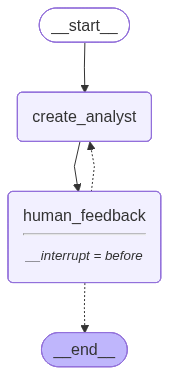

In [78]:

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [79]:
topic = "the benefits of adopting Langgraph as an agent framework"

In [80]:
max_analysts = 4

In [81]:
thread =  {"configurable":{"thread_id":1}}

In [82]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  
            

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Carter
Affiliation: Tech Innovations Lab
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of adopting Langgraph, emphasizing its modular architecture and ease of integration with existing systems. She is particularly interested in how Langgraph can enhance the efficiency of AI agents in various applications.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Global Market Insights
Role: Business Analyst
Description: Mr. Liu analyzes the market trends and business implications of adopting Langgraph. He is concerned with the cost-benefit analysis and how Langgraph can provide a competitive edge to businesses in the AI landscape.
--------------------------------------------------
Name: Dr. Sarah Thompson
Affiliation: Institute for AI Ethics
Role: Ethics and Compliance Advisor
Description: Dr. Thompson examines the ethical considerations surrounding the use of Langgraph as an agent framework. She is f

In [83]:
state = graph.get_state(thread)

In [84]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Emily Carter', role='AI Framework Specialist', affiliation='Tech Innovations Lab', description='Dr. Carter focuses on the technical advantages of adopting Langgraph, emphasizing its modular architecture and ease of integration with existing systems. She is particularly interested in how Langgraph can enhance the efficiency of AI agents in various applications.'), Analyst(name='Mr. James Liu', role='Business Analyst', affiliation='Global Market Insights', description='Mr. Liu analyzes the market trends and business implications of adopting Langgraph. He is concerned with the cost-benefit analysis and how Langgraph can provide a competitive edge to businesses in the AI landscape.'), Analyst(name='Dr. Sarah Thompson', role='Ethics and Compliance Advisor', affiliation='Institute for AI Ethics', description='Dr. Thompson examines the ethical considerat

In [85]:
state.next

('human_feedback',)

In [86]:

graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a6863-87c5-686c-8002-cbe6d6769b03'}}

In [87]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovations Lab
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of adopting Langgraph, emphasizing its modular architecture and ease of integration with existing systems. She is particularly interested in how Langgraph can enhance the efficiency of AI agents in various applications.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Global Market Insights
Role: Business Analyst
Description: Mr. Liu analyzes the market trends and business implications of adopting Langgraph. He is concerned with the cost-benefit analysis and how Langgraph can provide a competitive edge to businesses in the AI landscape.
--------------------------------------------------
Name: Dr. Sarah Thompson
Affiliation: Institute for AI Ethics
Role: Ethics and Compliance Advisor
Description: Dr. Thompson examines the ethical considerations surrounding the use of Langgraph as an agent framework. She is f

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Jordan Lee
Affiliation: Tech Startup Insights
Role: Startup Innovation Analyst
Description: Jordan focuses on the impact of emerging technologies on startup growth and scalability. With a keen interest in agent frameworks, they analyze how Langgraph can streamline operations and enhance product offerings for new ventures.
--------------------------------------------------
Name: Samantha Patel
Affiliation: Enterprise Tech Review
Role: Enterprise Solutions Analyst
Description: Samantha specializes in evaluating enterprise applications of new technologies. She explores how Langgraph can improve efficiency and collaboration within large organizations, emphasizing its integration capabilities with existing systems.
--------------------------------------------------
Name: Michael Chen
Affiliation: Future of AI Consulting
Role: AI Adoption Strategist
Description: Michael advises businesses on the strategic adoption of AI technologies. He examines the benefits of Langgraph in automating 

Date 11/10/2025


In [88]:
state = graph.get_state(thread)

In [89]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Jordan Lee', role='Startup Innovation Analyst', affiliation='Tech Startup Insights', description='Jordan focuses on the impact of emerging technologies on startup growth and scalability. With a keen interest in agent frameworks, they analyze how Langgraph can streamline operations and enhance product offerings for new ventures.'), Analyst(name='Samantha Patel', role='Enterprise Solutions Analyst', affiliation='Enterprise Tech Review', description='Samantha specializes in evaluating enterprise applications of new technologies. She explores how Langgraph can improve efficiency and collaboration within large organizations, emphasizing its integration capabilities with existing systems.'), Analyst(name='Michael Chen', role='AI Adoption St

In [90]:
state.next

('human_feedback',)

In [91]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application',
 'analysts': [Analyst(name='Jordan Lee', role='Startup Innovation Analyst', affiliation='Tech Startup Insights', description='Jordan focuses on the impact of emerging technologies on startup growth and scalability. With a keen interest in agent frameworks, they analyze how Langgraph can streamline operations and enhance product offerings for new ventures.'),
  Analyst(name='Samantha Patel', role='Enterprise Solutions Analyst', affiliation='Enterprise Tech Review', description='Samantha specializes in evaluating enterprise applications of new technologies. She explores how Langgraph can improve efficiency and collaboration within large organizations, emphasizing its integration capabilities with existing systems.'),
  Analyst(name='Michael Chen', role='AI Adoption Strategist', aff

In [92]:
# import msgpack

# def get_all_checkpoints(memory, thread_id="1"):
#     """Return all checkpoints in chronological order for a thread."""
#     checkpoints = []
#     ns_dict = memory.storage.get(thread_id, {})
#     if "" not in ns_dict:
#         return []

#     for ckpt_id, (packed_values, packed_meta, parent_id) in ns_dict[""].items():
#         values = msgpack.unpackb(packed_values[1], raw=False)
#         meta = msgpack.unpackb(packed_meta[1], raw=False)
#         checkpoints.append({
#             "id": ckpt_id,
#             "parent": parent_id,
#             "topic": values.get("topic"),
#             "feedback": values.get("human_analyst_feedback"),
#             "analyst_count": len(values.get("analysts", [])),
#             "analysts": [a.model_dump() for a in values.get("analysts", [])],
#             "step": meta.get("step"),
#             "created_at": values.get("ts", None)
#         })
#     return checkpoints

# # Fetch all
# history = get_all_checkpoints(memory)

# # Sort by step (to get chronological order)
# history = sorted(history, key=lambda x: (x["step"] or 0))

# # Display neatly
# for h in history:
#     print(f"\nSTEP {h['step']} | CHECKPOINT {h['id']}")
#     print(f"Parent: {h['parent']}")
#     print(f"Topic: {h['topic']}")
#     print(f"Feedback: {h['feedback']}")
#     print(f"Analysts generated: {h['analyst_count']}")
#     print("-"*100)

In [93]:
# If we are satisfied, then we simply supply no feedback
further_feedack = ""

In [94]:
# 1) Get the latest state (you're paused at 'human_feedback')
state = graph.get_state(thread)

# 2) Use the exact config from that state (it already has thread_id, checkpoint_ns, checkpoint_id)
cfg = state.config

In [95]:
# 3) Update feedback at the 'human_feedback' node
#    Tip: if your TypedDict says `human_analyst_feedback: str`, prefer "" (empty string) over None
graph.update_state(cfg, {"human_analyst_feedback": ""}, as_node="human_feedback")

KeyError: None

In [ ]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)

In [ ]:
analysts = final_state.values.get('analysts')

In [ ]:
analysts

In [ ]:

for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

In [ ]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

True

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


## Second Workflow

In [101]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [102]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key=os.getenv("TAVILY_API_KEY")

In [103]:
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

C:\Users\NidhiPal\AppData\Local\Temp\ipykernel_25504\1029971610.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)


In [104]:
tavily_search.invoke("langgraph")

[{'title': 'LangGraph: A Framework for Building Stateful Multi-Agent LLM ...',
  'url': 'https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03',
  'content': '> LangGraph is a powerful Python library designed for constructing stateful, multi-actor applications with Large Language Models (LLMs). It extends the capabilities of LangChain Expression Language (LCEL) while specifically addressing limitations in existing frameworks for agent development. As a specialized tool for creating complex LLM applications, LangGraph provides a structured approach to building sophisticated workflows that require cyclical processing patterns. [...] LangGraph represents a significant advancement in the toolkit available for developing sophisticated LLM applications, particularly those involving agent-like behaviors and multi-agent coordination. By extending LangChain with support for cyclical workflows and robust state management, it addresses k

In [105]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023,

In [119]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [120]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [121]:
print(analyst.persona)

Name: Aisha Thompson
Role: Market Trends Researcher
Affiliation: Global Tech Trends
Description: Aisha analyzes market trends and consumer behavior related to AI frameworks. She investigates the competitive advantages that Langgraph offers to both startups and established enterprises, focusing on its adaptability and user-friendliness.



In [122]:
question_instructions.format(goals = analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Aisha Thompson\nRole: Market Trends Researcher\nAffiliation: Global Tech Trends\nDescription: Aisha analyzes market trends and consumer behavior related to AI frameworks. She investigates the competitive advantages that Langgraph offers to both startups and established enterprises, focusing on its adaptability and user-friendliness.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview w

In [123]:

def generation_question(state:InterviewState):
    """Node to generate the questions"""
    
    #get state
    analyst = state["analyst"]
    messages = state["messages"]
    
    #generate the question
    system_message = question_instructions.format(goals = analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
    
    #returen the question through state
    return {"messages":[question]}

In [124]:

analyst

Analyst(name='Aisha Thompson', role='Market Trends Researcher', affiliation='Global Tech Trends', description='Aisha analyzes market trends and consumer behavior related to AI frameworks. She investigates the competitive advantages that Langgraph offers to both startups and established enterprises, focusing on its adaptability and user-friendliness.')

In [107]:
interview_builder = StateGraph(InterviewState)

In [125]:
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

In [127]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[HumanMessage(content="hi do the proper search according to the experties")]}

In [128]:
state

{'max_num_turns': 2,
 'context': [],
 'analyst': Analyst(name='Aisha Thompson', role='Market Trends Researcher', affiliation='Global Tech Trends', description='Aisha analyzes market trends and consumer behavior related to AI frameworks. She investigates the competitive advantages that Langgraph offers to both startups and established enterprises, focusing on its adaptability and user-friendliness.'),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='hi do the proper search according to the experties', additional_kwargs={}, response_metadata={})]}

In [129]:
result = generation_question(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [130]:
result

{'messages': [AIMessage(content="Hello Aisha, my name is Jordan Lee, and I'm an analyst focused on understanding market trends in technology. I'm really excited to speak with you today about your insights on AI frameworks, particularly regarding Langgraph. \n\nTo start off, could you share what you find to be the most surprising competitive advantage that Langgraph offers to both startups and established enterprises?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 230, 'total_tokens': 301, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CPlqJ2ZXCs70xQLUsP7o8tJdDz9KW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--703d182b-fc60-4458-bdc7-

In [131]:
print(result["messages"][0].content)

Hello Aisha, my name is Jordan Lee, and I'm an analyst focused on understanding market trends in technology. I'm really excited to speak with you today about your insights on AI frameworks, particularly regarding Langgraph. 

To start off, could you share what you find to be the most surprising competitive advantage that Langgraph offers to both startups and established enterprises?


In [132]:
from langchain_core.messages import get_buffer_string

In [133]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [134]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [135]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


In [136]:
result = search_web(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [137]:
print(result["context"][0])

<Document href="https://www.ibm.com/think/topics/langgraph"/>
*   [Overview](https://www.ibm.com/think/topics/ai-agents#7281535) *   [Overview](https://www.ibm.com/think/topics/components-of-ai-agents#498277090) *   [Learning](https://www.ibm.com/think/topics/ai-agent-learning#498277087) *   [Tutorial: LangGraph ReAct agent](https://www.ibm.com/think/tutorials/deploy-langgraph-react-agent-manage-it-support-tickets-watsonx-ai#1287801557) *   [Overview](https://www.ibm.com/think/topics/ai-agent-protocols#1509394340) *   [Tutorial: LangGraph ReAct agent](https://www.ibm.com/think/tutorials/deploy-langgraph-react-agent-manage-it-support-tickets-watsonx-ai#80364620) *   [Overview](https://www.ibm.com/think/insights/ai-agent-governance#1268897081) *   [Overview](https://www.ibm.com/think/topics/ai-agent-use-cases#257779831) *   [Human resources](https://www.ibm.com/think/topics/ai-agents-in-human-resources#257779835) LangGraph, created by [LangChain](https://www.ibm.com/think/topics/langchai

In [138]:
def search_wikipedia(state:InterviewState):
    """
    Retrieve data from wiki
    """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    print("*******************************")
    print(search_query)
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

In [139]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


In [140]:
result = search_wikipedia(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='What is Langgraph and how does it drive innovation and support digital transformation for businesses?'


In [141]:
search_docs = WikipediaLoader(query='Langgraph framework benefits',load_all_available_meta=True).load()


In [142]:
search_docs

[]

In [143]:
result

{'context': ['']}

In [144]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [145]:
def generate_answer(state:InterviewState):
   
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

In [146]:
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

In [147]:
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

In [148]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [149]:
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

In [150]:
interview_builder = StateGraph(InterviewState)

In [151]:
interview_builder.add_node("ask_question",generation_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)

In [152]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           route_messages,
                           ["ask_question",
                            "save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [153]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")


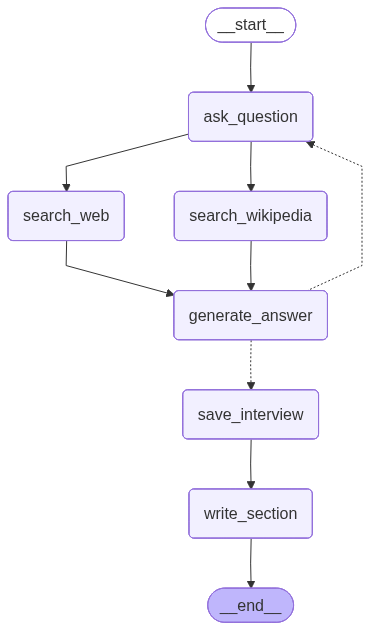

In [154]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))


## Skeleton flow 2

In [ ]:
# def ask_question(state:InterviewState):
#     """

#     Args:
#         state (InterviewState): _description_
#     """
#     pass

In [ ]:
# def search_web(state:InterviewState):
#     """

#     Args:
#         state (InterviewState): _description_
#     """
#     pass

In [ ]:
# def search_wikipedia(state:InterviewState):
#     """

#     Args:
#         state (InterviewState): _description_
#     """
#     pass

In [ ]:
# def generate_answer(state:InterviewState):
#     """

#     Args:
#         state (InterviewState): _description_
#     """
#     pass

In [ ]:
# def router_messages(state:InterviewState):
#     """

#     Args:
#         state (InterviewState): _description_
#     """
#     pass

In [ ]:
# def save_interview(state:InterviewState):
#     """

#     Args:
#         state (InterviewState): _description_
#     """
#     pass

In [ ]:
# def write_section(state:InterviewState):
#     """

#     Args:
#         state (InterviewState): _description_
#     """
#     pass

In [115]:
interview_builder.add_node("ask_question",ask_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)

In [116]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           router_messages,
                           ["ask_question",
                            "save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [117]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")


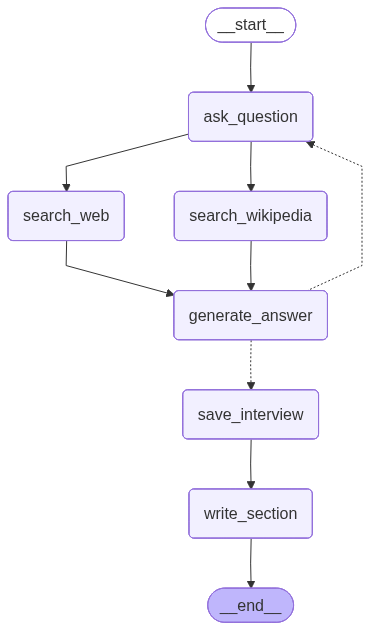

In [118]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))


In [155]:
analyst

Analyst(name='Aisha Thompson', role='Market Trends Researcher', affiliation='Global Tech Trends', description='Aisha analyzes market trends and consumer behavior related to AI frameworks. She investigates the competitive advantages that Langgraph offers to both startups and established enterprises, focusing on its adaptability and user-friendliness.')

In [156]:
analyst.persona

'Name: Aisha Thompson\nRole: Market Trends Researcher\nAffiliation: Global Tech Trends\nDescription: Aisha analyzes market trends and consumer behavior related to AI frameworks. She investigates the competitive advantages that Langgraph offers to both startups and established enterprises, focusing on its adaptability and user-friendliness.\n'

In [157]:
thread = {"configurable": {"thread_id": "1"}}


In [158]:
from IPython.display import Markdown

In [159]:
messages = [HumanMessage("So you said you were writing an article on Langchain?")]

In [160]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langchain adaptability compared to other AI frameworks features use cases'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='LangChain features for startups and enterprises, examples of companies using LangChain successfully'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [161]:
Markdown(interview['sections'][0])

## Analyzing the Competitive Edge of Langgraph in AI Frameworks

### Summary
The landscape of AI frameworks is rapidly evolving, with LangChain and LangGraph emerging as prominent players. LangChain has gained significant traction due to its user-friendly design and extensive integrations, allowing organizations to deploy LLM-powered applications with remarkable efficiency. Reports indicate that LangChain can reduce deployment times by 3–5 times and cut manual data engineering efforts by 60–80% [1][2]. This adaptability makes it particularly appealing to both startups and established enterprises looking to leverage AI capabilities without extensive resources.

LangGraph, built on the foundation of LangChain, introduces a graph-based architecture that enhances its ability to manage stateful applications and complex decision-making processes. This feature is particularly beneficial for scenarios requiring multi-agent collaboration, where independent AI agents must coordinate effectively [3][4]. The combination of LangChain's orchestration capabilities and LangGraph's advanced features positions them as complementary tools rather than direct competitors, catering to a wide range of use cases from chatbots to specialized AI tools [5][6].

Interestingly, the open-source nature of both frameworks has fostered a vibrant community of developers, contributing to their rapid evolution and accessibility. LangChain's extensive documentation and community-driven resources have lowered the barrier to entry for developers at all levels, democratizing AI application development [7][8]. This trend is reflected in the growing number of companies adopting these frameworks, with over 100,000 organizations reportedly utilizing LangChain for their AI needs [9].

The insights gathered from various sources highlight the competitive advantages that Langgraph offers, particularly in its adaptability and user-friendliness. As organizations increasingly seek to integrate AI into their operations, frameworks like LangChain and LangGraph are poised to play a pivotal role in shaping the future of AI application development.

### Sources
[1] https://kanerika.com/blogs/autogen-vs-langchain/  
[2] https://www.designveloper.com/blog/langchain-use-cases/  
[3] https://milvus.io/blog/langchain-vs-langgraph.md  
[4] https://www.curotec.com/insights/langchain-vs-langgraph-framework-comparison/  
[5] https://akka.io/blog/langchain-alternatives/  
[6] https://www.pingcap.com/article/langchain-transforming-development-with-key-benefits/  
[7] https://www.designveloper.com/blog/what-is-langchain/  
[8] https://www.langchain.com/customers/  
[9] https://datasciencedojo.com/blog/what-is-langchain/  

## Third Workflow

In [172]:
from typing_extensions import TypedDict
from typing import List, Annotated
import operator

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

In [163]:
from langgraph.types import Send


In [175]:
def initiate_all_interviews(state:ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """ 
    
    #check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"
    
    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                        "messages": [HumanMessage(
                                            content=f"So you said you were writing an article on {topic}?"
                                        )
                                                ]}) for analyst in state["analysts"]]

In [165]:
# def write_report(state:ResearchGraphState):
#     """_summary_

#     Args:
#         state (ResearchGraphState): _description_
#     """
#     pass

In [176]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [ ]:
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

In [177]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [178]:
def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

In [ ]:
def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

In [169]:
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

In [179]:
# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

In [180]:
memory = MemorySaver()

In [181]:
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)


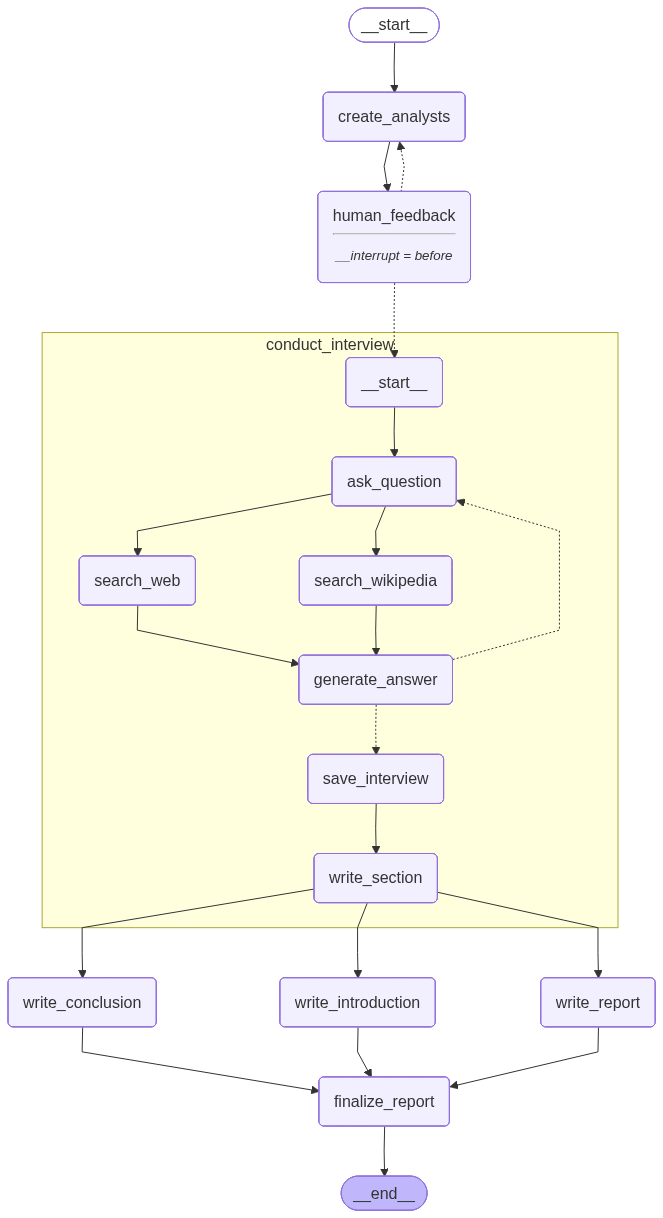

In [182]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## mega assisgnment

1. connnect multiple data source
2. how to divide this artitecture on a grnular level